In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, minimize
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("../data/modular_theory2007/Data_Modular_Theory2007.csv", engine="c")

In [3]:
def response_rate(df, trialname):
    n = (df.event == 8).sum()
    t = df["time_"+trialname].iloc[-1]
    return 60 * (n/t)

interval = 30
trialname = "FI{}".format(interval)

idx = ((data["trial_"+trialname] > 0)
       & (data.phase=="acquisition"))

df_rate = (data[idx].groupby(["subject", "session", "trial_"+trialname])
                    .apply(response_rate, trialname)
                    .pipe(pd.DataFrame)
                    .reset_index()
                    .rename(columns={"trial_"+trialname:"trial", 0:"rpm"})
          )

In [4]:
def ssr(ydata, yfit):
    """Return the sum of squared residuals"""
    return ((ydata-yfit)**2).sum()

def constraints(θ, θ_bounds):
    """Check bounds on parameters"""
    if (θ<θ_bounds[0]).any() or (θ>θ_bounds[1]).any():
        return False
    return True

def sem(f, xdata, ydata, θ_init):
    """Return the standard error of the estimates"""
    tol = 1e-6
    θ_bounds = [θ_init-tol, θ_init+tol] 
    θ_hat, θ_cov  = curve_fit(f, xdata, ydata, θ_init, bounds=θ_bounds)
    θ_sem = np.sqrt(np.diag(θ_cov))
    return θ_sem, θ_hat

In [5]:
def rescorla_wagner(xdata, α, A):
    """Return the predictions from the RW model"""
    ntrials = xdata.size
    V = np.zeros(ntrials)
    for trial in range(1, ntrials):
        V[trial] = V[trial-1] + α*(1-V[trial-1])
    return A*V

def rw_fit_wrapper(θ, ydata, θ_bounds):
    """Return goodness-of-fit for the RW model evaluated at θ"""
    α, A = θ
    if not constraints(θ, θ_bounds):
        return 1e9
    yfit = rescorla_wagner(ydata, α, A)
    return ssr(ydata, yfit)

def pd_fit_rw(df):
    """Fit the RW model to a single DF worth of data"""
    xdata = df.trial
    ydata = df.rpm
    
    # Useful starting parameters from the data.
    θ_init = [0.05, ydata.max()]
    θ_bounds = [(0, 0), (1, np.inf)]
    θ_hat = minimize(rw_fit_wrapper, θ_init, args=(ydata, θ_bounds), method="Nelder-Mead", options={"maxiter":1e4})
    θ_sem = sem(rescorla_wagner, xdata, ydata, θ_hat.x)[0]
    return θ_hat.x, θ_sem

df_rw_rate_fit = (df_rate.groupby("subject")
                      .apply(pd_fit_rw)         # fit the gradient
                      .apply(pd.Series)         # unpack θopt and θerr
                      .unstack()                # transpose
                      .apply(pd.Series)         # unpack the parameters
                      .reset_index()
                      .rename(columns={"level_0": "is_sem", 0:"α", 1:"A"})
              )

/Users/davidfreestone/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()


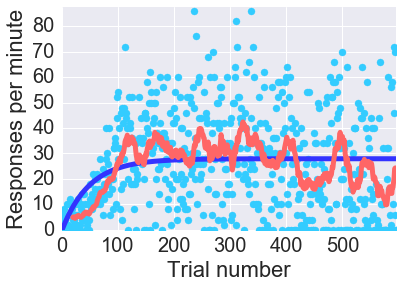

In [7]:
def show_rw_fit(subject):
    xdata = df_rate[df_rate.subject==subject].trial
    ydata = df_rate[df_rate.subject==subject].rpm
    ydata_smooth = pd.rolling_mean(ydata, 20)

    fit = df_rw_rate_fit.ix[(df_rw_rate_fit.subject==subject) & ~df_rw_rate_fit.is_sem]
    yfit = rescorla_wagner(xdata, *fit[["α", "A"]].as_matrix()[0])
    
    fig, ax = plt.subplots()
    ax.plot(xdata, yfit, zorder=2, linewidth=5, color="#3333ff")
    ax.plot(xdata, ydata_smooth, zorder=2, linewidth=5, color="#ff6666")
    ax.scatter(xdata, ydata, s=50, zorder=1, color="#33ccff")
    ax.set_xlim((0, xdata.max()))
    ax.set_ylim((0, 1.02*ydata.max()))
    ax.tick_params(labelsize=20)
    ax.set_xlabel("Trial number", fontsize=22)
    ax.set_ylabel("Responses per minute", fontsize=22)
    
show_rw_fit(433)

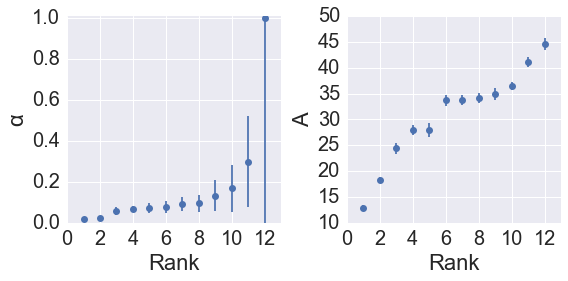

In [8]:
def show_parameter(df, parameter, ax=None):
    θhat = np.vstack([df.ix[df.is_sem==0, parameter].as_matrix(),
                      df.ix[df.is_sem!=0, parameter].as_matrix()]).transpose()
    θhat = θhat[θhat[:, 0].argsort()]
    
    if ax is None:
        fig, ax = plt.subplots()
    #ax.bar(range(1, 1+θhat.shape[0]),
    #       θhat[:,0], align="center")
    ax.errorbar(range(1, 1+θhat.shape[0]),
                θhat[:,0], yerr=θhat[:,1],
                fmt="o", linestyle="")
    ax.set_xlabel("Rank", fontsize=22)
    ax.set_ylabel(parameter, fontsize=22)
    ax.tick_params(labelsize=20)
    return ax

fig, ax = plt.subplots(figsize=(8,4), nrows=1, ncols=2)

show_parameter(df_rw_rate_fit, "α", ax[0])
show_parameter(df_rw_rate_fit, "A", ax[1])

ax[0].set_ylim((-0.001, 1.01))
ax[0].set_xlim((0, 13))
ax[1].set_xlim((0, 13))
fig.tight_layout()

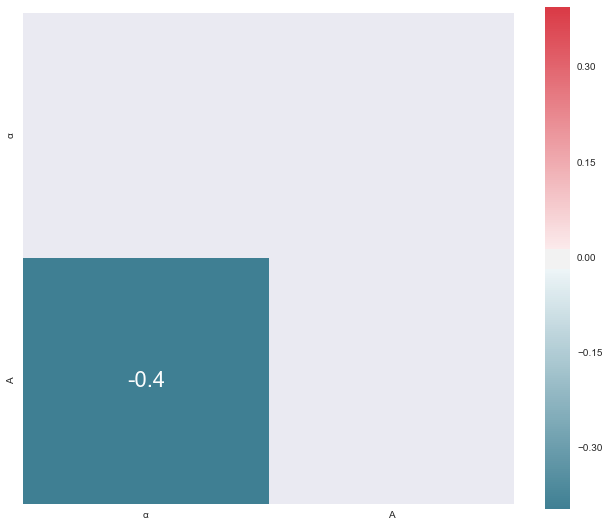

In [9]:
def corrplot(df, parameters):
    corr = df.ix[df.is_sem==0, parameters].corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                annot=True, annot_kws={"size":22}, square=True)
    
corrplot(df_rw_rate_fit, ["α", "A"])

array([    6453.96474619,      215.13491343,        5.92878618,
        6607592.3147497 ])

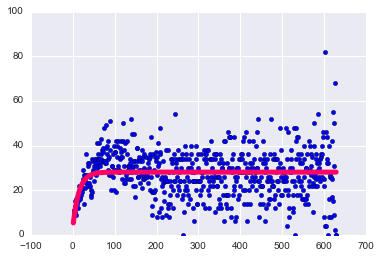

In [10]:
def mt_learningcurve(ntrials, βr, βe, R0, A):
    d, T = 1, interval # set above!
    w0 = 0
    w = βr*d / (βr*d + βe*T)
    W = np.zeros(ntrials)
    # loop over trials.
    for n in range(1, ntrials):
        W[n] = w + (w0-w)*((1 - βr*d - βe*T)**n)
    return A*W + R0

def mt_fit_wrapper(θ, ydata, θ_bounds):
    if not constraints(θ, θ_bounds):
        return 1e9
    ntrials = ydata.size
    
    βr, βe, R0, A = θ
    yfit = mt_learningcurve(ntrials, βr, βe, R0, A)
    return ssr(ydata, yfit)

df_mean_rpm = df_rate.groupby("trial").median().reset_index()
#df_mean_rpm.rpm.plot()

xdata = df_mean_rpm.trial
ydata = df_mean_rpm.rpm

θ_bounds = [np.array([0, 0, 0, 0]), np.array([.1, .1, ydata.max(), ydata.max()])]
θ_init = [0.05, 0.05, 5, 30]

θ_hat = minimize(mt_fit_wrapper, θ_init, args=(ydata, θ_bounds), method="Nelder-Mead", options={"maxiter":1e4})
θ_sem = sem(mt_learningcurve, xdata.size, ydata, θ_hat.x)[0]

plt.scatter(xdata, ydata, s=20)
plt.plot(xdata, mt_learningcurve(xdata.size, *θ_hat.x), linewidth=5, color="#ff0066")

plt.ylim((0, 100))
#plt.xlim((0, 700))

np.set_printoptions(suppress=True)
#print(θopt) #θerr

median_θopt = θ_hat
θ_sem

In [11]:
def pd_fit_mt(df):
    xdata = df.trial
    ydata = df.rpm

    # Useful starting parameters from the data.
    θ_bounds = [np.array([0, 0, 0, 0]), np.array([.1, .1, ydata.max(), ydata.max()])]
    θ_init = median_θopt.x
    θ_hat = minimize(mt_fit_wrapper, θ_init, args=(ydata, θ_bounds), method="Nelder-Mead", options={"maxiter":1e4})
    θ_sem = sem(mt_learningcurve, xdata.size, ydata, θ_hat.x)[0]
    return θ_hat.x, θ_sem

df_mt_rate_fit = (df_rate.groupby("subject")
                      .apply(pd_fit_mt)         # fit the gradient
                      .apply(pd.Series)         # unpack θopt and θerr
                      .unstack()                # transpose
                      .apply(pd.Series)         # unpack the parameters
                      .reset_index()
                      .rename(columns={"level_0": "is_sem", 0:"βr", 1:"βe", 2:"R0", 3:"A"})
              )

/Users/davidfreestone/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()


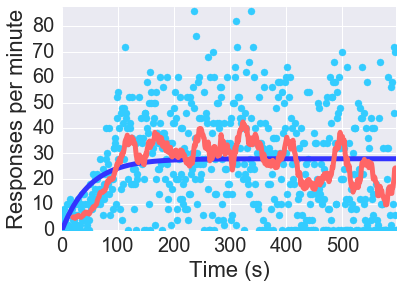

In [12]:
def show_mt_fit(subject):
    xdata = df_rate[df_rate.subject==subject].trial
    ydata = df_rate[df_rate.subject==subject].rpm
    ydata_smooth = pd.rolling_mean(ydata, 20)

    fit = df_mt_rate_fit.ix[(df_mt_rate_fit.subject==subject) & ~df_mt_rate_fit.is_sem]
    yfit = mt_learningcurve(xdata.size, *fit[["βr", "βe", "R0", "A"]].as_matrix()[0])
    
    fig, ax = plt.subplots()
    ax.plot(xdata, yfit, zorder=2, linewidth=5, color="#3333ff")
    ax.plot(xdata, ydata_smooth, zorder=2, linewidth=5, color="#ff6666")
    ax.scatter(xdata, ydata, s=50, zorder=1, color="#33ccff")
    ax.set_xlim((0, xdata.max()))
    ax.set_ylim((0, 1.02*ydata.max()))
    ax.tick_params(labelsize=20)
    ax.set_xlabel("Time (s)", fontsize=22)
    ax.set_ylabel("Responses per minute", fontsize=22)
    return ax

show_mt_fit(433)
#list(map(show_mt_fit, df_mt_rate_fit.subject.unique()))

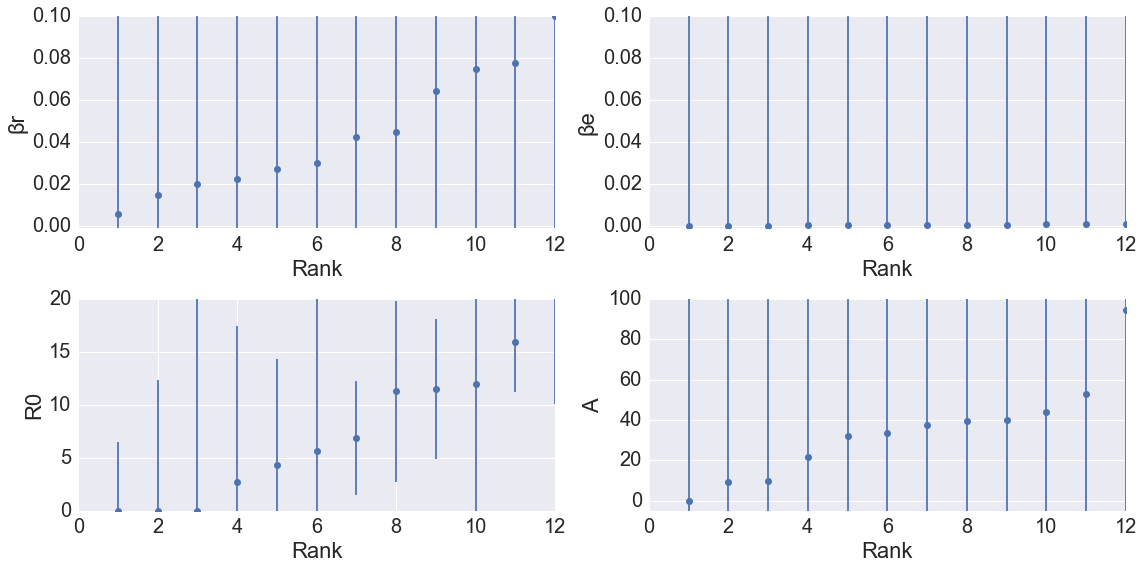

In [13]:
fig, ax = plt.subplots(figsize=(16,8), nrows=2, ncols=2)

show_parameter(df_mt_rate_fit, "βr", ax[0,0])
show_parameter(df_mt_rate_fit, "βe", ax[0,1])
show_parameter(df_mt_rate_fit, "R0", ax[1,0])
show_parameter(df_mt_rate_fit, "A", ax[1,1])

ax[0,0].set_ylim((-0.001, .1))
ax[0,1].set_ylim((-0.001, .1))
ax[1,0].set_ylim((-0.001, 20))
ax[1,1].set_ylim((-5, 100))

fig.tight_layout()

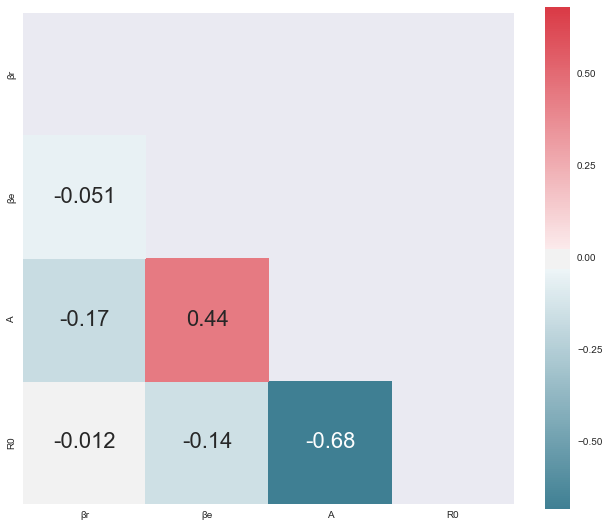

In [14]:
corrplot(df_mt_rate_fit, ["βr", "βe", "A", "R0"])

In [15]:
def recover_parameters(ntrials, βr, βe, R0, A):
    xdata = np.arange(ntrials)
    ydata = mt_learningcurve(ntrials, βr, βe, R0, A, 1, interval)

    θ_bounds = [θ_lower, θ_upper]
    θ_init = np.array([βr, βe, R0, A]) + 0.1*np.array([βr, βe, R0, A])*np.random.rand(4)#[0.05, 0.05, 5, 30]
    
    θ_hat = minimize(mt_fit_wrapper, θ_init, args=(ydata, θ_bounds), method="Nelder-Mead", options={"maxiter":1e4})
    θ_sem = np.nan + np.zeros(θ_hat.x.size)
    if not θ_hat.success:
        return np.nan + np.zeros(5)
    return np.hstack((θ_hat.x, θ_hat.fun))#, θ_sem


θ_lower = np.array([0.0001, 0.0001, 0, 0])
θ_upper = np.array([1, 1, 10, 100])
θ_true = np.zeros((1000, 4))
θ_hat = np.zeros((1000, 5))
for i in range(1000):
    θ_true[i,] = θ_lower + (θ_upper-θ_lower)*np.random.rand(θ_lower.size)
    θ_hat[i,] = recover_parameters(200, *θ_true[i,])

TypeError: mt_learningcurve() takes 5 positional arguments but 7 were given

In [76]:
isgood = np.isfinite(θ_hat).all(axis=1)
θ_hat = θ_hat[isgood,]
θ_true = θ_true[isgood,]

for i in range(4):
    print(np.corrcoef(θ_true[:,i], θ_hat[:,i])[0,1])

0.994136680583
0.998676700115
0.992545060733
0.99396976612


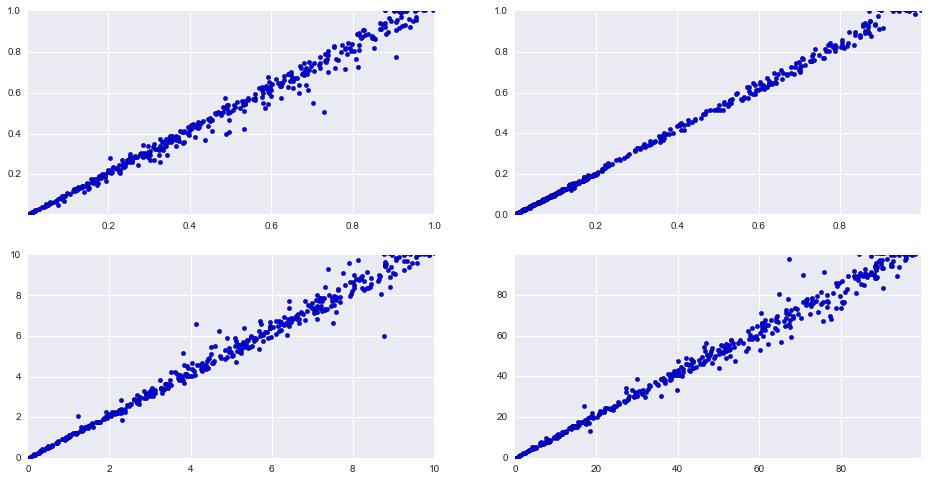

In [77]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
ax = ax.ravel()

for i in range(4):
    ax[i].scatter(θ_true[:,i], θ_hat[:,i])
    ax[i].set_xlim((θ_true[:,i].min(), θ_true[:,i].max()))
    ax[i].set_ylim((θ_true[:,i].min(), θ_true[:,i].max()))

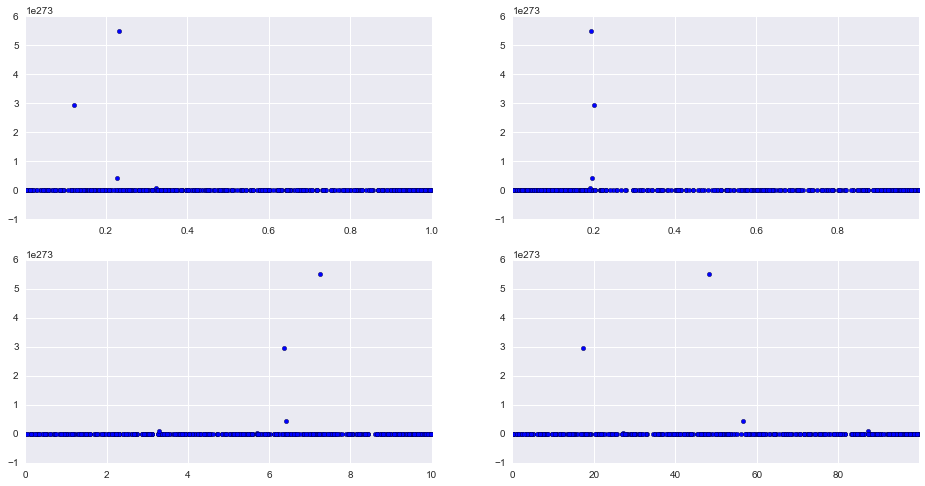

In [78]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
ax = ax.ravel()

for i in range(4):
    ax[i].scatter(θ_true[:,i], θ_hat[:,4])
    ax[i].set_xlim((θ_true[:,i].min(), θ_true[:,i].max()))
    #ax[i].set_ylim((θ_true[:,i].min(), θ_true[:,i].max()))